In [1]:
import os
from pathlib import Path
import zipfile, kaggle

In [2]:
path = Path('titanic')
if not path.exists(): #downloading from kaggle api
    kaggle.api.competition_download_cli(str(path))
    zipfile.ZipFile(f'{path}.zip').extractall(path)

In [3]:
import torch, numpy as np, pandas as pd
np.set_printoptions(linewidth=140)
torch.set_printoptions(linewidth=140, sci_mode=False, edgeitems=7)
pd.set_option('display.width', 140)

In [4]:
df = pd.read_csv(path/'train.csv')
df.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [5]:
df.isna().sum() 
# We note lots of missing values for age and cabin

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [6]:
modes = df.mode().iloc[0]
modes

PassengerId                      1
Survived                       0.0
Pclass                         3.0
Name           Abbing, Mr. Anthony
Sex                           male
Age                           24.0
SibSp                          0.0
Parch                          0.0
Ticket                        1601
Fare                          8.05
Cabin                      B96 B98
Embarked                         S
Name: 0, dtype: object

In [7]:
df.fillna(modes, inplace=True) #Filling in missing values with the mode

In [8]:
df.isna().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
dtype: int64

<Axes: >

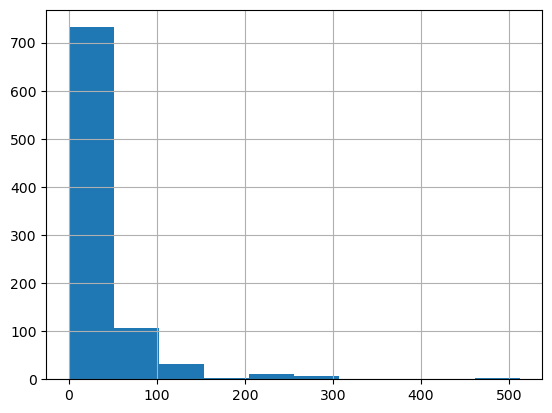

In [9]:
df['Fare'].hist()

In [10]:
#transform hist to prevent long postive skew from affecting results
df['Logfare'] = np.log(df['Fare'] + 1) #prevents 0 values 

<Axes: >

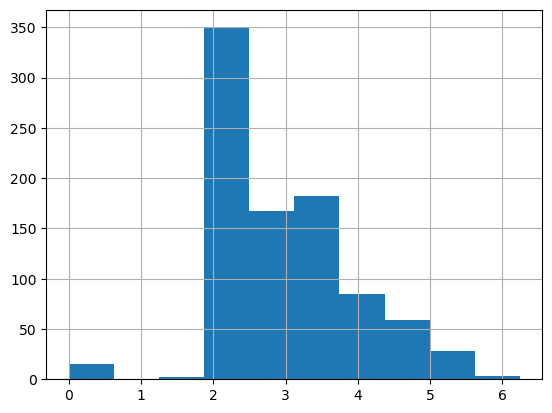

In [11]:
df['Logfare'].hist()

In [12]:
df.Pclass.value_counts()

Pclass
3    491
1    216
2    184
Name: count, dtype: int64

In [13]:
df.describe(include = [object])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,891,891
unique,891,2,681,147,3
top,"Braund, Mr. Owen Harris",male,347082,B96 B98,S
freq,1,577,7,691,646


In [14]:
df = pd.get_dummies(df, columns = ['Sex', 'Pclass', 'Embarked'], dtype = 'float')
df.columns
#one - hot encoding

Index(['PassengerId', 'Survived', 'Name', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Logfare', 'Sex_female', 'Sex_male',
       'Pclass_1', 'Pclass_2', 'Pclass_3', 'Embarked_C', 'Embarked_Q', 'Embarked_S'],
      dtype='object')

In [15]:
df.columns

Index(['PassengerId', 'Survived', 'Name', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Logfare', 'Sex_female', 'Sex_male',
       'Pclass_1', 'Pclass_2', 'Pclass_3', 'Embarked_C', 'Embarked_Q', 'Embarked_S'],
      dtype='object')

In [16]:
added_cols = ['Sex_male', 'Sex_female', 'Pclass_1', 'Pclass_2', 'Pclass_3', 'Embarked_C', 'Embarked_Q', 'Embarked_S']
df[added_cols].head(10)

,Sex_male,Sex_female,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S
0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
2,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
3,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
4,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
5,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
6,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
7,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
8,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
9,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0


In [17]:
from torch import tensor
t_dep = tensor(df.Survived)

In [18]:
indep_cols = ['Age', 'SibSp', 'Parch', 'Logfare'] + added_cols
t_indep = tensor(df[indep_cols].values, dtype = torch.float)
t_indep

tensor([[22.0000,  1.0000,  0.0000,  2.1102,  1.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000],
        [38.0000,  1.0000,  0.0000,  4.2806,  0.0000,  1.0000,  1.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000],
        [26.0000,  0.0000,  0.0000,  2.1889,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000],
        [35.0000,  1.0000,  0.0000,  3.9908,  0.0000,  1.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  1.0000],
        [35.0000,  0.0000,  0.0000,  2.2028,  1.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000],
        [24.0000,  0.0000,  0.0000,  2.2469,  1.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  1.0000,  0.0000],
        [54.0000,  0.0000,  0.0000,  3.9677,  1.0000,  0.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  1.0000],
        ...,
        [25.0000,  0.0000,  0.0000,  2.0857,  1.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000],
        [39.0000,  0.0000,  5.0000,  3.4054

In [19]:
t_indep.size()

torch.Size([891, 12])

In [20]:
len(t_indep.shape) # Matrix is rank 2 tensor

2

# Linear Model

In [21]:
#Creating random coefficients, 1 coefficient for 1 column. Don't need a constant?
#Re-seed 
torch.manual_seed(17)

n_coeff = t_indep.shape[1]
coeffs = (torch.rand(n_coeff) - 0.5) # Centered around 0
coeffs

tensor([-0.0658,  0.0351,  0.3302, -0.3761, -0.4707,  0.0494, -0.1175,  0.0463, -0.0317, -0.4828, -0.4786, -0.1336])

In [22]:
t_indep * coeffs 

tensor([[-1.4467,  0.0351,  0.0000, -0.7937, -0.4707,  0.0000, -0.0000,  0.0000, -0.0317, -0.0000, -0.0000, -0.1336],
        [-2.4988,  0.0351,  0.0000, -1.6101, -0.0000,  0.0494, -0.1175,  0.0000, -0.0000, -0.4828, -0.0000, -0.0000],
        [-1.7097,  0.0000,  0.0000, -0.8233, -0.0000,  0.0494, -0.0000,  0.0000, -0.0317, -0.0000, -0.0000, -0.1336],
        [-2.3016,  0.0351,  0.0000, -1.5011, -0.0000,  0.0494, -0.1175,  0.0000, -0.0000, -0.0000, -0.0000, -0.1336],
        [-2.3016,  0.0000,  0.0000, -0.8285, -0.4707,  0.0000, -0.0000,  0.0000, -0.0317, -0.0000, -0.0000, -0.1336],
        [-1.5782,  0.0000,  0.0000, -0.8451, -0.4707,  0.0000, -0.0000,  0.0000, -0.0317, -0.0000, -0.4786, -0.0000],
        [-3.5510,  0.0000,  0.0000, -1.4924, -0.4707,  0.0000, -0.1175,  0.0000, -0.0000, -0.0000, -0.0000, -0.1336],
        ...,
        [-1.6440,  0.0000,  0.0000, -0.7845, -0.4707,  0.0000, -0.0000,  0.0000, -0.0317, -0.0000, -0.0000, -0.1336],
        [-2.5646,  0.0000,  1.6510, -1.2809

In [76]:
t_indep

tensor([[0.2750, 0.1250, 0.0000, 0.3381, 1.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000],
        [0.4750, 0.1250, 0.0000, 0.6859, 0.0000, 1.0000, 1.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000],
        [0.3250, 0.0000, 0.0000, 0.3507, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000],
        [0.4375, 0.1250, 0.0000, 0.6395, 0.0000, 1.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.4375, 0.0000, 0.0000, 0.3530, 1.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000],
        [0.3000, 0.0000, 0.0000, 0.3600, 1.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 1.0000, 0.0000],
        [0.6750, 0.0000, 0.0000, 0.6358, 1.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        ...,
        [0.3125, 0.0000, 0.0000, 0.3342, 1.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000],
        [0.4875, 0.0000, 0.8333, 0.5456, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000, 0.0000, 1.0000, 0.0000],
        [0.3375, 0.0000, 0.0000, 

In [77]:
vals, indices = t_indep.max(dim=0)
vals

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [ ]:
t_indep = t_indep/vals #scaling by max value

In [ ]:
t

In [24]:
preds = (t_indep*coeffs).sum(axis=1)
preds.shape

torch.Size([891])

In [25]:
loss = torch.abs(preds - t_dep).mean()
loss

tensor(1.1156)

In [26]:
def calc_preds(coeffs, indep):
    return (indep*coeffs).sum(axis=1)
def calc_loss(coeffs, indep , dep ):
    return torch.abs(calc_preds(coeffs, indep) - dep).mean()


## Performing a Gradient Descent Step 

In [27]:
coeffs.requires_grad_() # remember an extra _ indicates that change is happening inplace

tensor([-0.0658,  0.0351,  0.3302, -0.3761, -0.4707,  0.0494, -0.1175,  0.0463, -0.0317, -0.4828, -0.4786, -0.1336], requires_grad=True)

In [28]:
loss = calc_loss(coeffs, t_indep, t_dep)
loss

tensor(1.1156, grad_fn=<MeanBackward0>)

In [29]:
loss.backward()

In [30]:
coeffs.grad

tensor([-0.3571, -0.0654, -0.0636, -0.4746, -0.6476, -0.3524, -0.2424, -0.2065, -0.5511, -0.1886, -0.0864, -0.7250])

In [31]:
learning_rate = 0.1
with torch.no_grad():
    coeffs.sub_(coeffs.grad*learning_rate)
    print(calc_loss(coeffs, t_indep, t_dep))

    

tensor(0.9292)


We note that the loss has gone down after 1 gradient descent step

# Training the Linear Model 

In [32]:
from fastai.data.transforms import RandomSplitter

trn_split,val_split=RandomSplitter(seed=17)(df)

In [34]:
trn_split

(#713) [302,196,109,24,56,91,780,851,183,656...]

In [35]:
trn_indep, val_indep = t_indep[trn_split], t_indep[val_split]

In [38]:
trn_dep, val_dep = t_dep[trn_split], t_dep[val_split]
len(trn_indep), len(val_indep)

(713, 178)

Moving previous steps into functions

In [39]:
def update_coeffs(coeffs, learning_rate):
    coeffs.sub_(coeffs.grad*learning_rate)

In [61]:
def one_epoch(coeffs, learning_rate):
    loss = calc_loss(coeffs, trn_indep, trn_dep)
    loss.backward()
    with torch.no_grad(): 
        update_coeffs(coeffs, learning_rate)
    print(f"{loss:.3f}", end="; ")

In [43]:
def init_coeffs():
    ''' Initialises random coefficients'''
    return (torch.rand(n_coeff)-0.5).requires_grad_()

In [62]:
def train_model(epochs=30, lr=0.01):
    torch.manual_seed(17)
    coeffs = init_coeffs()
    for i in range(epochs):
        one_epoch(coeffs,lr)
    return coeffs

In [63]:
coeffs = train_model(18,0.02)

1.123; 1.086; 1.012; 0.902; 0.772; 0.618; 0.503; 0.502; 0.514; 0.551; 0.646; 0.753; 0.850; 0.924; 0.981; 1.017; 1.025; 1.001; 

In [66]:
def show_coeffs():
    return dict(zip(indep_cols, coeffs))
show_coeffs()

{'Age': tensor(0.3781, grad_fn=<UnbindBackward0>),
 'SibSp': tensor(0.0901, grad_fn=<UnbindBackward0>),
 'Parch': tensor(0.3891, grad_fn=<UnbindBackward0>),
 'Logfare': tensor(0.2711, grad_fn=<UnbindBackward0>),
 'Sex_male': tensor(0.1765, grad_fn=<UnbindBackward0>),
 'Sex_female': tensor(0.6398, grad_fn=<UnbindBackward0>),
 'Pclass_1': tensor(0.3979, grad_fn=<UnbindBackward0>),
 'Pclass_2': tensor(0.2827, grad_fn=<UnbindBackward0>),
 'Pclass_3': tensor(0.4541, grad_fn=<UnbindBackward0>),
 'Embarked_C': tensor(-0.0129, grad_fn=<UnbindBackward0>),
 'Embarked_Q': tensor(-0.2767, grad_fn=<UnbindBackward0>),
 'Embarked_S': tensor(0.4321, grad_fn=<UnbindBackward0>)}

# Measuring Accuracy

In [67]:
preds = calc_preds(coeffs, val_indep)

In [68]:
results = val_dep.bool() == (preds > 0.5)
results[:16]

tensor([False,  True,  True,  True,  True,  True, False, False,  True, False,  True,  True,  True, False, False, False])

In [69]:
results.float().mean()

tensor(0.3371)

In [70]:
def acc(coeffs):
    preds = calc_preds(coeffs, val_indep)
    results = val_dep.bool() == (preds > 0.5)
    return results.float().mean()

# Using sigmoid

In [71]:
preds[:28]

tensor([1.5807, 1.0871, 1.2888, 0.8131, 1.7181, 1.8396, 1.3277, 0.8132, 1.3202, 0.8510, 1.3175, 0.8661, 1.4403, 1.2574, 1.1240, 1.2604,
        1.2715, 0.7604, 1.9806, 1.4829, 0.8781, 1.4085, 1.3223, 1.2804, 1.0248, 1.7040, 1.5826, 1.1134], grad_fn=<SliceBackward0>)

We are getting greater than 1 chance of survival which is impossible.